<strong><font size="8">A2</font></strong>

In [3]:
import mne
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib

data_path = mne.datasets.sample.data_path()

print(f"{mne.__version__=}")
print(data_path)

mne.__version__='1.9.0'
C:\Users\snowy\mne_data\MNE-sample-data


<strong><font size="6">1</font></strong>

In [4]:
#------- SETUP -------#
raw_path = os.path.join(data_path, "MEG", "sample", "sample_audvis_raw.fif") #finds sample data in storage
subjects_path = os.path.join(data_path, "subjects") #subject in storage
coreg = os.path.join(data_path, "MEG", "sample", "sample_audvis_raw-trans.fif") #finds coregistration matrix "trans" file

subject = "sample"
src_space = mne.setup_source_space(subject, spacing="ico4", subjects_dir = subjects_path, add_dist = "False") #sets up source space

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\snowy\mne_data\MNE-sample-data\subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\surf\lh.white...
Mapping lh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/155407 selected to source space (ico = 4)

Loading C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\surf\rh.white...
Mapping rh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/156866 selec

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
outer skin  CM is  -0.12  -0.14  22.79 mm
outer skull CM is   0.70  -9.88  44.01 mm
inner skull CM is   0.67 -10.01  44.26 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    3.7 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    3.5 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        

C:\Users\snowy\miniforge3\envs\4cn3-a2\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


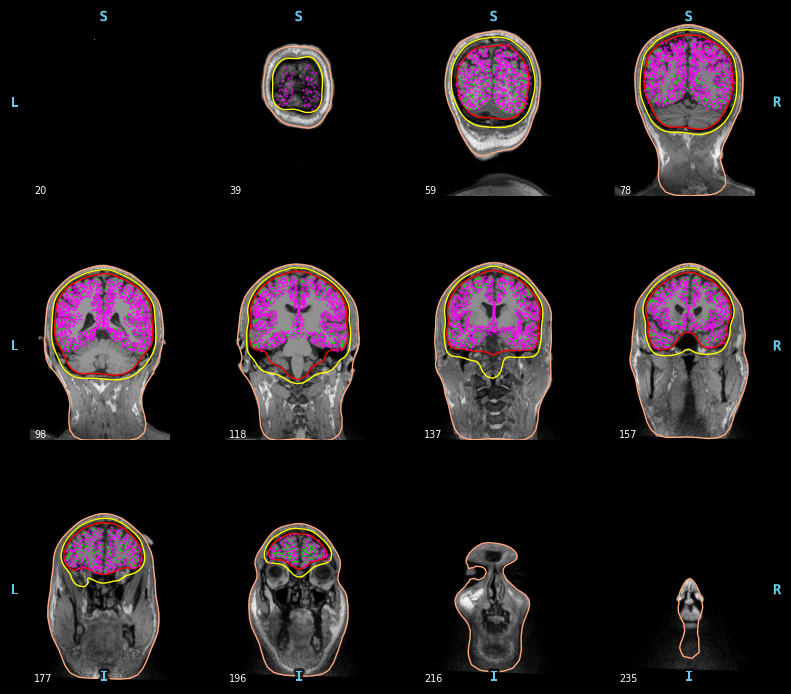

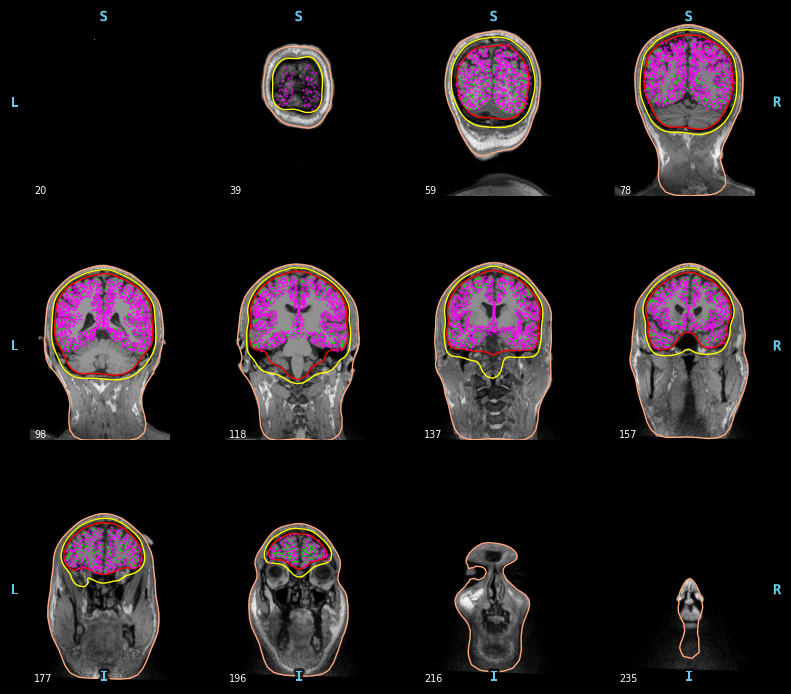

In [5]:
#------- BEM MODEL -------#
bem_model = mne.make_bem_model(subject=subject, subjects_dir=subjects_path) #creates 3-layer bem model. Default conductivity and ico spacing (ico4) used
bem = mne.make_bem_solution(bem_model) #calculates bem solution

bem_plot = mne.viz.plot_bem(subject=subject, subjects_dir=subjects_path, brain_surfaces='white', orientation='coronal', src=src_space) #plots source space

In [7]:
#------- FORWARD SOLUTION -------#
fwd_unconst = mne.make_forward_solution(raw_path, trans=coreg, src=src_space, bem=bem, meg=True, eeg=True, mindist=5.0) #forward solution for both MEG and EEG, unconstrained
fwd = mne.convert_forward_solution(fwd_unconst, surf_ori=True, force_fixed=True, use_cps=True) #fwd sol w/ fixed orientation constraint

#------- LEADFIELD -------#
leadfield = fwd['sol']['data'] #extracts leadfield
print("Leadfield size : %d sensors x %d sources" % leadfield.shape)


Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=2562>, <surface (rh), n_vertices=156866, n_used=2562>] MRI (surface RAS) coords, subject 'sample', ~33.0 MiB>
MRI -> head transform : C:\Users\snowy\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw-trans.fif
Measurement data      : sample_audvis_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999310 0.009985 -0.035787      -3.17 mm
    0.012759 0.812405 0.582954       6.86 mm
    0.034894 -0.583008 0.811716      28.88 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991420 -0.039936 -0.124467      -6.13 mm
    0.060661 0.984012 0.167456       0.06 mm
    0.115790 -0.173570 0.977991 

<strong><font size="4.5">1 (A)</font></strong>

In [27]:
#------- LABEL INFO EXTRACTION -------#

labels = mne.read_labels_from_annot(subject=subject, parc='aparc', subjects_dir=subjects_path)
# print(labels) #for finding name of transverse temporal gyrus 

lh_label = [label for label in labels if label.name == "transversetemporal-lh"][0] #finds the labels only associated w/ the gryus'
rh_label = [label for label in labels if label.name == "transversetemporal-rh"][0]
# print(np.shape(lh_label.vertices))

#------- LABEL VISUALIZATION -------#

brain = mne.viz.Brain(subject=subject, subjects_dir=subjects_path, hemi="both", surf="inflated") #whole brain 
brain.add_label(lh_label, color="red") #labels/brain areas highlighted in red
brain.add_label(rh_label, color="red")

#------- VERTEX IDENTIFICATION -------#

lh_vertex = fwd['src'][0]['vertno'] #left hemisphere source vertex locations
rh_vertex = fwd['src'][1]['vertno'] #right hemisphere source vertex locations
# print(np.shape(lh_vertex))
# print(np.shape(rh_vertex))
# print(np.shape(leadfield))

lh_sources = np.intersect1d(lh_label.vertices, lh_vertex) #finds the verticies existing in both the transverse temporal and the source space
rh_sources = np.intersect1d(rh_label.vertices, rh_vertex)

lh_index = np.where(np.isin(lh_vertex, lh_label.vertices))[0] #indecies of the source space verticies within the superset of the Freesurfer vertex IDs
rh_index = np.where(np.isin(rh_vertex, rh_label.vertices))[0] #NOTE: the [0] is required otherwise we get an array of 2 elements, w/ one holding indecies and one empty
rh_index = np.add(rh_index, len(lh_vertex)) #since SourceSpace aka "labels" reps seperately, but leadfield concatonates, we have to add the total size of the left hemisphere array to the index to get proper index in leadfield

#------- SOURCE SIMULATION -------#

#L = n_sensors x n_sources
lh_leadfield = leadfield[:, lh_index] #leadfield for the values that exist in the left hemisphere of the source space
rh_leadfield = leadfield[:, rh_index] #leadfield for rh
# print(np.shape(leadfield))
# print(lh_index)
# print(np.shape(lh_index))
# print(np.shape(lh_leadfield))
# print(np.shape(rh_leadfield))

#J = n_sources x n_times (n_times = 1 since we're doing constant current)
lh_currents = np.ones(len(lh_index)) #equal source current (1) for each existing index
rh_currents = np.ones(len(rh_index))

#Y = LJ (linear combination)
lh_simulated = lh_leadfield @ lh_currents #matrix-vector multiplication 
rh_simulated = rh_leadfield @ rh_currents
# simulated = np.concatenate((lh_simulated, rh_simulated)) #total simulated data, concatenated
# simulated = lh_simulated + rh_simulated
# print(np.shape(simulated_lh))
# print(np.shape(simulated))


Reading labels from parcellation...
   read 34 labels from C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\label\lh.aparc.annot
   read 34 labels from C:\Users\snowy\mne_data\MNE-sample-data\subjects\sample\label\rh.aparc.annot
True


<strong><font size="4.5">1 (B)</font></strong>

Opening raw data file C:\Users\snowy\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


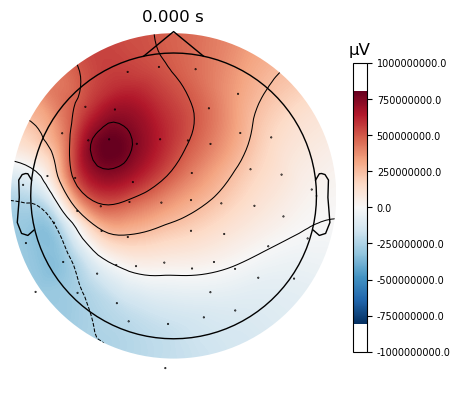

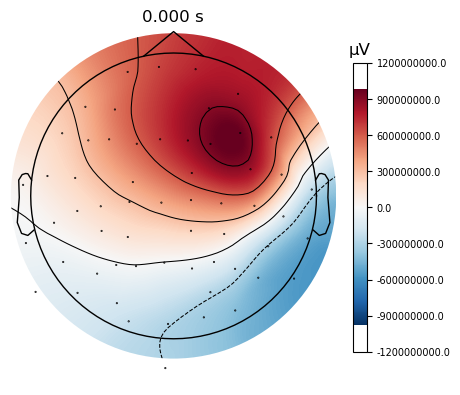

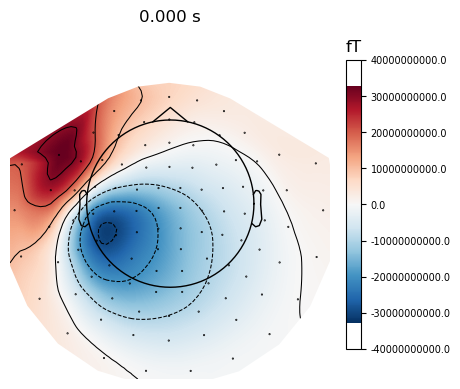

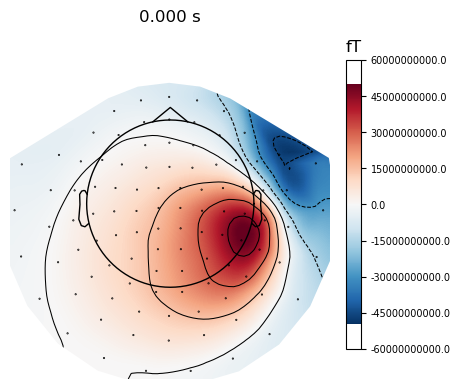

In [28]:
#------- VISUALIZATION SETUP -------#
raw = mne.io.read_raw_fif(raw_path, preload=True) #preloads data into memory for processing

ch_index = mne.pick_types(raw.info, meg=True, eeg=True, exclude=[]) #finds relevant M/EEG channels

info = mne.pick_info(raw.info, ch_index) #extracts info from channels

# print(np.shape(simulated))
lh_simulated = lh_simulated.reshape(-1, 1) #adds dimension to make it a 2D array since required for EvokedArray
rh_simulated = rh_simulated.reshape(-1, 1) 

lh_evoked = mne.EvokedArray(lh_simulated, info)
rh_evoked = mne.EvokedArray(rh_simulated, info)

#------- VISUALIZATION -------#

lh_eeg = lh_evoked.plot_topomap(times=0, ch_type="eeg", size=3)
rh_eeg = rh_evoked.plot_topomap(times=0, ch_type="eeg", size=3)
lh_meg = lh_evoked.plot_topomap(times=0, ch_type="mag", size=3)
rh_meg = rh_evoked.plot_topomap(times=0, ch_type="mag", size=3)

<strong><font size="4.5">1 (C)</font></strong>

True
Opening raw data file C:\Users\snowy\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


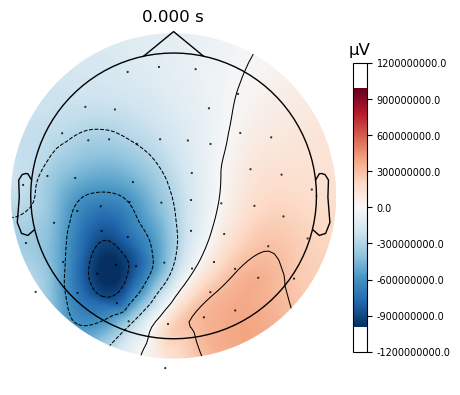

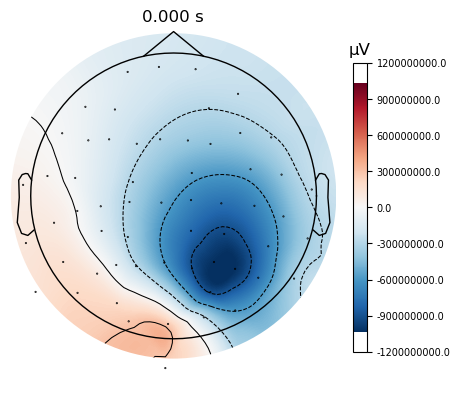

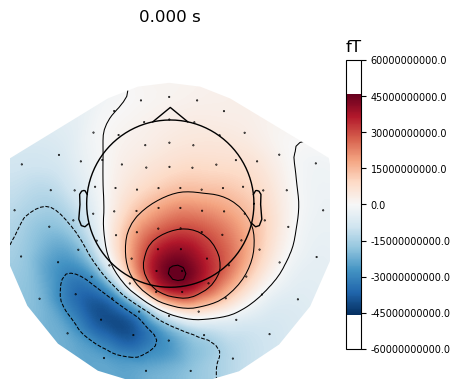

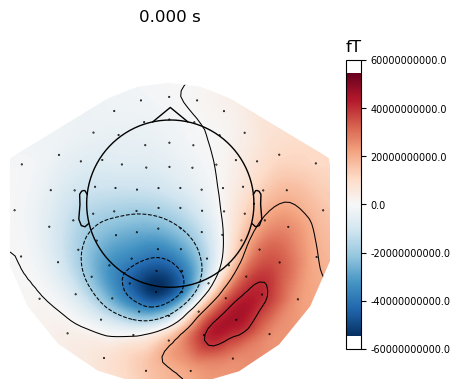

In [26]:
#------- LABEL INFO EXTRACTION -------#

# print(labels)
lh_label = [label for label in labels if label.name == "pericalcarine-lh"][0] #finds the labels only associated w/ the gryus'
rh_label = [label for label in labels if label.name == "pericalcarine-rh"][0]

#------- LABEL VISUALIZATION -------#

brain = mne.viz.Brain(subject=subject, subjects_dir=subjects_path, hemi="both", surf="inflated") #whole brain 
brain.add_label(lh_label, color="red") #labels/brain areas highlighted in red
brain.add_label(rh_label, color="red")

#------- VERTEX IDENTIFICATION -------#

lh_vertex = fwd['src'][0]['vertno'] #left hemisphere source vertex locations
rh_vertex = fwd['src'][1]['vertno'] #right hemisphere source vertex locations

lh_sources = np.intersect1d(lh_label.vertices, lh_vertex) #finds the verticies existing in both the transverse temporal and the source space
rh_sources = np.intersect1d(rh_label.vertices, rh_vertex)

lh_index = np.where(np.isin(lh_vertex, lh_label.vertices))[0] #indecies of the source space verticies within the superset of the Freesurfer vertex IDs
rh_index = np.where(np.isin(rh_vertex, rh_label.vertices))[0] 
rh_index = np.add(rh_index, len(lh_vertex)) 

#------- SOURCE SIMULATION -------#

#L = n_sensors x n_sources
lh_leadfield = leadfield[:, lh_index] #leadfield for the values that exist in the left hemisphere of the source space
rh_leadfield = leadfield[:, rh_index] #leadfield for rh

#J = n_sources x n_times (n_times = 1 since we're doing constant current)
lh_currents = np.ones(len(lh_index)) #equal source current (1) for each existing index
rh_currents = np.ones(len(rh_index))

#Y = LJ (linear combination)
lh_simulated = lh_leadfield @ lh_currents #matrix-vector multiplication 
rh_simulated = rh_leadfield @ rh_currents
# simulated = np.concatenate((lh_simulated, rh_simulated)) #total simulated data, concatenated
simulated = lh_simulated + rh_simulated

#------- VISUALIZATION SETUP -------#
raw = mne.io.read_raw_fif(raw_path, preload=True) #preloads data into memory for processing

ch_index = mne.pick_types(raw.info, meg=True, eeg=True, exclude=[]) #finds relevant M/EEG channels

info = mne.pick_info(raw.info, ch_index) #extracts info from channels

# print(np.shape(simulated))
lh_simulated = lh_simulated.reshape(-1, 1) #adds dimension to make it a 2D array since required for EvokedArray
rh_simulated = rh_simulated.reshape(-1, 1) 

lh_evoked = mne.EvokedArray(lh_simulated, info)
rh_evoked = mne.EvokedArray(rh_simulated, info)

#------- VISUALIZATION -------#

lh_eeg = lh_evoked.plot_topomap(times=0, ch_type="eeg", size=3)
rh_eeg = rh_evoked.plot_topomap(times=0, ch_type="eeg", size=3)
lh_meg = lh_evoked.plot_topomap(times=0, ch_type="mag", size=3)
rh_meg = rh_evoked.plot_topomap(times=0, ch_type="mag", size=3)

<strong><font size="4.5">1 (D)</font></strong>

The head maps are very similar to the results from Assignment 1. 

If we look at the left and right hemisphere EEG responses (first 2 images), we can see that it is similar to the EEG responses for the auditory channel (although with opposite polarity). We can see a strong response in the frontal lobe, with the polarization appearing on the relevant side of the brain. Similarly, the MEG responses (next 2 images) show a strong polarization surrounding the left and right gyri respectively, which can be located by looking at the highlighted red section when the full brain is visualized. 

For the visual response, the mapping is even more close, with the ~100ms mark showing very similar polarization patterns in the relevant part of the occipital lobes. This holds true for both the EEG and MEG data, with the MEG data displaying in nearly the exact same way as Assignment 1. 

The main difference between this assignment and Assingment 1 was in the EEG data. While the MEG data was quite consistent between them, it seems that the noise experienced when using real sources instead of a simulated source made a less clear image of the response. This can be seen when observing the extreme localization of EEG readings in each hemisphere that are visible in this assignment, as compared to the more general frontal lobe polarization seen in Assignment 1